In [1]:
import numpy as np
import torch
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from PIL import Image
from scripts.inference import parse_opt, check_img_size, \
    non_max_suppression, scale_boxes, increment_path, YOLOv9t_Seq, select_device, colors, yaml_load, letterbox, Annotator

### 
# opt = parse_opt()


In [3]:
from scripts.modules import *
def dump_layer(model:torch.Tensor, save_path:str):
    with open(save_path, 'w') as f:
        # shape C,H,W,N = 16,320,320,1
        # type = f32 or f16
        # model = model.permute(0, 1, 2, 3)

        f.write(f"# {model.shape[0]}, {model.shape[1]}, {model.shape[2]}, {model.shape[3]}\n")
        f.write(f"# {model.dtype}\n")
        lines = model.detach().cpu()
        lines = lines.permute(0, 2, 3, 1).numpy().reshape(-1)
        lines = ' '.join([f"{x:.4f}" for x in lines])
        f.write(f"{lines}")

class YOLOv9t_Seq(nn.Module):
    """YOLOv9-t model implementation"""
    def __init__(self, ch=3, nc=80):
        super().__init__()
        self.nc = nc
        
        # Sequential model with all layers
        self.model = nn.Sequential(
            Conv(ch, 16, 3, 2),              # 0-P1/2
            Conv(16, 32, 3, 2),              # 1-P2/4
            ELAN1(32, 32, 32, 16),           # 2
            AConv(32, 64),                   # 3-P3/8
            RepNCSPELAN4(64, 64, 64, 32, 3), # 4
            AConv(64, 96),                   # 5-P4/16
            RepNCSPELAN4(96, 96, 96, 48, 3), # 6
            AConv(96, 128),                  # 7-P5/32
            RepNCSPELAN4(128, 128, 128, 64, 3), # 8
            SPPELAN(128, 128, 64),           # 9
            
            nn.Upsample(None, 2, 'nearest'), # 10
            Concat(1),                       # 11-cat backbone P4(5)
            RepNCSPELAN4(224, 96, 96, 48, 3), # 12
            nn.Upsample(None, 2, 'nearest'), # 13
            Concat(1),                       # 14 cat backbone P3(3)
            RepNCSPELAN4(160, 64, 64, 32, 3), # 15 - N3 output
            AConv(64, 48),                   # 16
            Concat(1),                       # 17 cat head P4()
            RepNCSPELAN4(144, 96, 96, 48, 3), # 18 - (P4/16-medium)
            AConv(96, 64),                   # 19
            Concat(1),                       # 20 cat head P5
            RepNCSPELAN4(192, 128, 128, 64, 3), # 21 - (P5/32-large)
        )
        
        # Detection head
        self.detect = Detect(nc, (64, 96, 128))  # 22
        self.stride = 32
        # Save indices for feature extraction
        self.save_indices = [3, 6, 9, 15, 18, 21]  # P3, P4, P5, N3, N4, N5
        
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass with intermediate feature extraction"""
        features  = {}
        # Pass through each layer and save specific outputs
        for i in range(len(self.model)):
            layer = self.model[i]
            
            # Handle Concat operations
            if isinstance(layer, Concat):
                if i == 11:  # Upsample(10) + P4(6)
                    x = layer([x, features[6]])
                elif i == 14:  # Upsample(13) + P3(3)  
                    x = layer([x, features[4]])
                elif i == 17:  # AConv(16) + P4(12) ← 수정!
                    x = layer([x, features[12]])  # layer 6이 아니라 12!
                elif i == 20:  # AConv(19) + P5(9) ← 여기는 맞음
                    x = layer([x, features[9]])
            else:
                x = layer(x)
            layer_name = layer.__class__.__name__
            
            # Save features needed for concat or output
            # if i in [4, 6, 9, 12, 15, 18, 21]:
            features[i] = x
        for i in features.keys():
            dump_layer(features[i], f"torch_yolov9t_detections_features_layer_{i}.txt")
        # Multi-scale detection outputs
        outputs = [features[15], features[18], features[21]]
        

        # Detection head
        if self.training:
            return self.detect(outputs)
        else:
            inference_out, raw_outputs = self.detect(outputs)
            return inference_out, raw_outputs


In [4]:


source = './tests/input/cat-and-hat.jpg'
weights = './scripts/yolov9t_converted.pth'
data = './tests/input/coco.yaml'
imgsz = 640
conf_thres = 0.25
iou_thres = 0.45
max_det = 1000
device = ''
half = False
device = select_device(0)
# model = DetectMultiBackend(opt.weights, device=device, data=opt.data, fp16=opt.half)

model = YOLOv9t_Seq().cuda()
model.load_state_dict(torch.load(weights, map_location='cpu', weights_only=False))
imgsz = check_img_size(imgsz, s=model.stride)
# Read image
im0 = cv2.imread(source)  # BGR
assert im0 is not None, f'Failed to load image: {source}'

# Preprocess
im = letterbox(im0, imgsz, stride=model.stride, auto=True)[0]
model.eval()

im = im.transpose((2, 0, 1))[::-1]  # HWC->CHW, BGR->RGB
im = np.ascontiguousarray(im)
names = yaml_load(data)['names']
im_tensor = torch.from_numpy(im).to(device)
im_tensor = im_tensor.half() if half else im_tensor.float()
im_tensor /= 255.0
if im_tensor.ndimension() == 3:
    im_tensor = im_tensor.unsqueeze(0)
dump_layer(im_tensor, f"torch_yolov9t_detections_input_tensor.txt")
print(f'Image shape: {im_tensor.shape}')  # torch.Size([1, 3, 640, 640])
# Inference
# model.warmup(imgsz=(1, 3, *imgsz))
pred = model(im_tensor)


Image shape: torch.Size([1, 3, 640, 640])


In [27]:
print(f'Image shape: {im_tensor.shape}')  # torch.Size([1, 3, 640, 640])
# Inference
# model.warmup(imgsz=(1, 3, *imgsz))
pred = model(im_tensor)
if len(pred[0]) != 4:
    res = pred[0].unsqueeze(0)
    dump_layer(res, f"torch_yolov9t_detections_predction.txt")
# if not isinstance(pred, list):
#     pred = [pred]
def print_shape(p):
    if isinstance(p, (list, tuple)):
        print("is list")
        print(len(p))
        for p in p:
            print_shape(p)
    else:
        print("is not list")
        print(p.shape)

# NMS
pred = non_max_suppression(pred, conf_thres, iou_thres, max_det=max_det)
# dump_layer(pred[0], f"torch_yolov9t_detections_output_tensor.txt")
# Draw boxes
annotator = Annotator(im0.copy(), line_width=3, example=str(list(names.values())))

det = pred[0]
if len(det):
    det[:, :4] = scale_boxes(im_tensor.shape[2:], det[:, :4], im0.shape).round()
    for *xyxy, conf, cls in det:
        c = int(cls)
        cname = names[c] if c in names else str(c)
        label = None if False else (cname if False else f'{cname} {conf:.2f}')
        for i in xyxy:
            print(i.detach().cpu().numpy(), label)
        annotator.box_label(xyxy, label, color=colors(c, True))

result = annotator.result()


Image shape: torch.Size([1, 3, 640, 640])
77.0 cat 0.96
167.0 cat 0.96
457.0 cat 0.96
469.0 cat 0.96
408.0 tv 0.50
1.0 tv 0.50
512.0 tv 0.50
160.0 tv 0.50
1.0 bed 0.25
311.0 bed 0.25
491.0 bed 0.25
510.0 bed 0.25


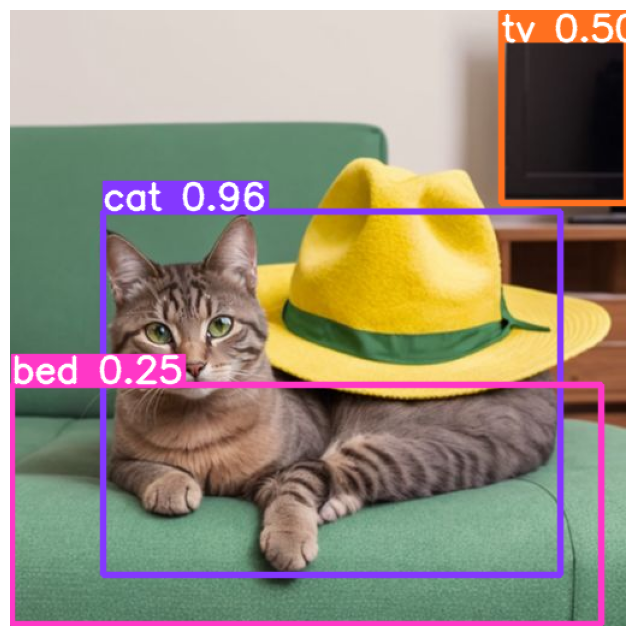

In [7]:
fig = plt.figure(figsize=(12, 8))
plt.imshow(result[:,:,::-1])
plt.axis('off')  # 축 표시 제거 (선택사항)
display(fig)

In [8]:
torch_layer = np.loadtxt('./torch_yolov9t_detections_input_tensor.txt', dtype=np.float32, delimiter=' ', skiprows=2)
torch_layer = torch_layer.reshape(3, 640, 640, 1)


In [9]:

gg_layer = np.loadtxt('./yolov9t_detections_input.txt', dtype=np.float32, delimiter=' ', skiprows=2)
print(gg_layer.shape)
gg_layer = gg_layer.reshape(3, 640, 640, 1)
print(gg_layer.shape)

(1068784,)


ValueError: cannot reshape array of size 1068784 into shape (3,640,640,1)

In [ ]:

abs_diff = np.abs(torch_layer-gg_layer)
diff_idx = np.argmax(abs_diff)
diff_max = np.max(abs_diff)
print(f"Max diff: {diff_max} at index {diff_idx}")

gg_layer.flatten()[diff_idx], torch_layer.flatten()[diff_idx]

torch_layer.mean(), gg_layer.mean()

In [ ]:
torch_txt_name = [f'torch_yolov9t_detections_features_layer_{i}.txt' for i in range(22)]
cpp_txt_name = [f'yolov9t_detections_features_layer_{i}.txt' for i in range(22)]
for t, c in zip(torch_txt_name, cpp_txt_name):
    
    # 첫번째 줄 '# 1, 16, 320, 320' 파싱하여 reshape
    torch_layer = np.loadtxt(t, dtype=np.float32, delimiter=' ', skiprows=2)
    def get_shape_from_file(t):
        with open(t, 'r') as f:
            first_line = f.readline().strip()
        shape_str = first_line.lstrip('# ').strip()
        shape = tuple(map(int, shape_str.split(',')))
        return shape
    shape = get_shape_from_file(t)
    # shape = tuple(reversed(shape))
    N, C, H, W = shape
    print(shape)
    # numpy.ascontiguousarray — NumPy v2.4.dev0 Manual16, 320, 320, 1
    torch_layer = np.ascontiguousarray(torch_layer.reshape(C, H, W, N))
    # torch_layer = torch_layer.transpose(0, 3, 2, 1)  # NCHW -> NHWC
    ###############################
    # ggml_type = NUMPY_DTYPE_TO_GGML_TYPE[x.dtype.type]
    #     shape = tuple(reversed(x.shape))
    #     tensor = ggml.ggml_new_tensor(
    #         ctx,
    #         ggml_type.value,
    #         len(shape),
    #         (ctypes.c_int64 * len(shape))(*shape),
    #     )
    #     tensor.contents.nb[: len(shape)] = (ctypes.c_int64 * len(shape))(
    #         *tuple(reversed(x.strides))
    #     )
    #     if ggml.ggml_get_data(tensor) is not None
    
    # 번째 줄 '# 16, 320, 320, 1' 파싱하여 reshape
    cpp_layer = np.loadtxt(c, dtype=np.float32, delimiter=' ', skiprows=2)
    shape = get_shape_from_file(c)
    C, W, H, N = shape
    
    print(shape)
    cpp_layer = cpp_layer.reshape(shape)
    # cpp_layer = np.transpose(cpp_layer, (3, 2, 1, 0))
    # cpp_layer = cpp_layer.transpose(3, 2, 1, 0)  # CHWN -> NHWC
    if torch_layer.shape != cpp_layer.shape:
        print(f"Shape mismatch: {torch_layer.shape} vs {cpp_layer.shape}")
        break
    abs_diff = np.abs(torch_layer-cpp_layer)
    diff_idx = np.argmax(abs_diff)
    diff_max = np.max(abs_diff)
    print(f"Max diff: {diff_max} at index {diff_idx}")
    # diff mean, std
    print(f"Mean diff: {np.mean(abs_diff)}, Std diff: {np.std(abs_diff)}")
    # if diff_max > 1e-5:
    print(cpp_layer.shape)
    print(torch_layer.shape)
    break
    #     print(f"  Torch value: {torch_layer[diff_idx]}, C++ value: {cpp_layer[diff_idx]}")

In [ ]:
# # 16, 320, 320, 1 의 1번째 차원과 2번째 차원의 축의 내용을 바꿔줘.
# torch_layer = np.swapaxes(torch_layer, 1, 2)
# torch_layer = np.ascontiguousarray(torch_layer)
# torch_layer

In [ ]:
from gguf.gguf_reader import GGUFReader
reader = GGUFReader('./models/yolov9t_converted.gguf')
for k, v in reader.fields.items():
    print(f"{k}")
for tensors in reader.tensors:
    name = tensors.name
    shape = tensors.shape
    data = tensors.data
    print(name, shape, data.shape)
    break
a = torch.load('./scripts/yolov9t_converted.pth', map_location='cpu', weights_only=False)
print(a[name].shape)
